In [ ]:
# Kernel Density Estimation
"""
Kernel density estimation (KDE) is in some senses an algorithm that takes the
mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one
Gaussian component per point, resulting in an essentially nonparametric estimator of
density
"""

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

/tmp/ipykernel_614825/3518078781.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
# Motivating Kernel Density Estimation: Histograms

def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x
x = make_data(1000)

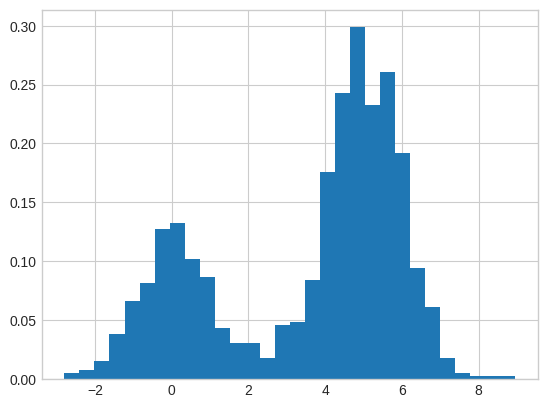

In [3]:
hist = plt.hist(x, bins=30, density=True)

In [4]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

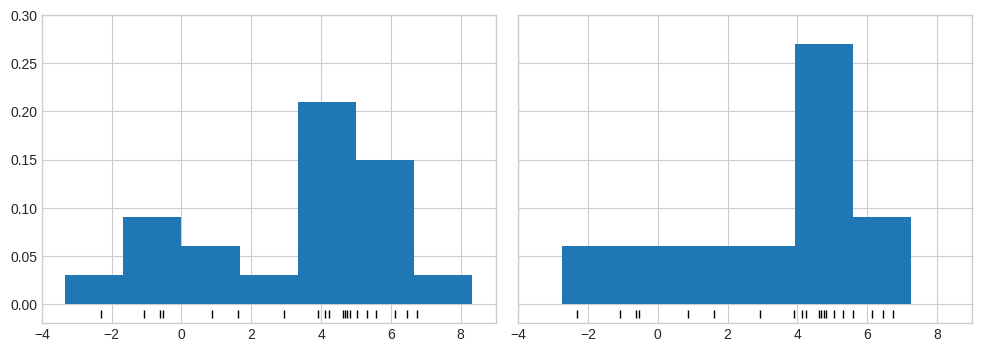

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
    sharex=True, sharey=True,
    subplot_kw={'xlim':(-4, 9),
    'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
        markeredgewidth=1)
    
# The problem with histograms: the bin locations can affect interpretation

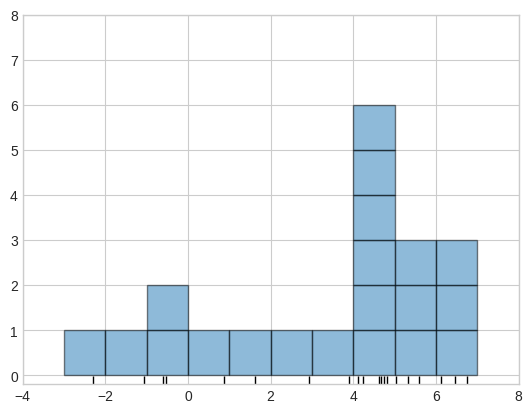

In [7]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle(
            (edge, i), 1, 1, ec='black', alpha=0.5))
    ax.set_xlim(-4, 8)
    ax.set_ylim(-0.2, 8)

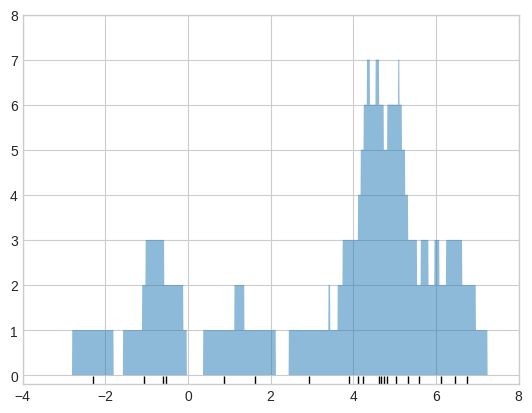

In [8]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 8]);

# A “histogram” where blocks center on each individual point; this is an
# example of a kernel density estimate

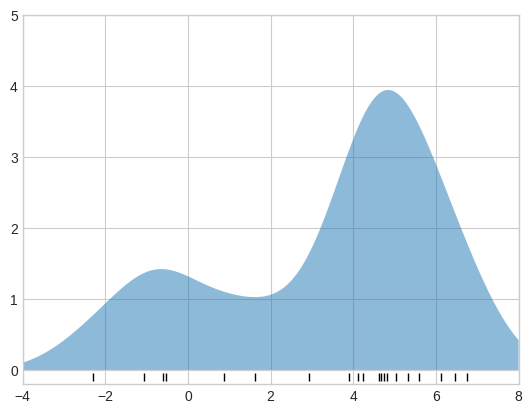

In [9]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 5]);

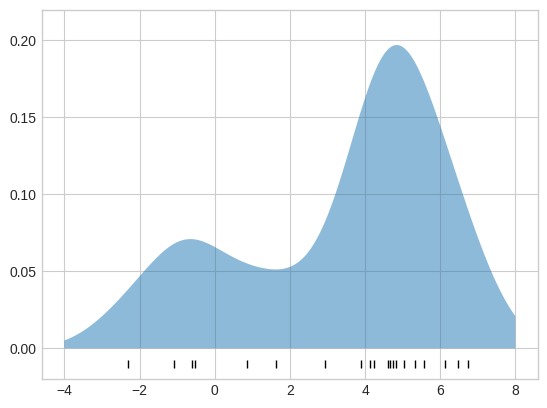

In [10]:
# Kernel Density Estimation in Practice

from sklearn.neighbors import KernelDensity
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])
plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22);

In [11]:
# Selecting the Bandwidth via Cross-Validation

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
{'bandwidth': bandwidths},
cv=LeaveOneOut())
grid.fit(x[:, None]);

In [12]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

In [ ]:
# Not-so-Naive Bayes - добавление к бейнзу - свойств KDE 
"""
1. Split the training data by label.
2. For each set, fit a KDE to obtain a generative model of the data. This allows you,
for any observation x and label y, to compute a likelihood P x y .
3. From the number of examples of each class in the training set, compute the class
prior, P y .
4. For an unknown point x, the posterior probability for each class is
P y x ∝ P x y P y . The class that maximizes this posterior is the label
assigned to the point.
"""

In [13]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    Parameters
    ----------
    bandwidth : float
    the kernel bandwidth within each class
    kernel : str
    the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
        kernel=self.kernel).fit(Xi)
        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
        for Xi in training_sets]
        return self
    
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
        for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(axis=1, keepdims=True)
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]
    

In [14]:
# Using Our Custom Estimator

from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
digits = load_digits()
grid = GridSearchCV(KDEClassifier(),
{'bandwidth': np.logspace(0, 2, 100)})
grid.fit(digits.data, digits.target);

best param: {'bandwidth': 6.135907273413174}
accuracy = 0.9677298050139276


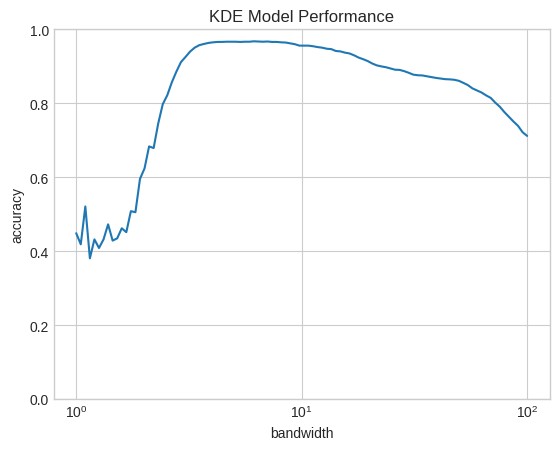

In [15]:
fig, ax = plt.subplots()
ax.semilogx(np.array(grid.cv_results_['param_bandwidth']),
grid.cv_results_['mean_test_score'])
ax.set(title='KDE Model Performance', ylim=(0, 1),
xlabel='bandwidth', ylabel='accuracy')
print(f'best param: {grid.best_params_}')
print(f'accuracy = {grid.best_score_}')

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.8069281956050759